## Setup the environment

In [1]:
from sys import executable
!{executable} -m pip install -U python-dotenv tqdm firebase-admin asyncio nest_asyncio aiohttp pandas numpy matplotlib pydrive

Requirement already up-to-date: python-dotenv in /usr/local/lib/python3.6/dist-packages (0.13.0)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.46.0)
Requirement already up-to-date: firebase-admin in /usr/local/lib/python3.6/dist-packages (4.2.0)
Requirement already up-to-date: asyncio in /usr/local/lib/python3.6/dist-packages (3.4.3)
Requirement already up-to-date: nest_asyncio in /usr/local/lib/python3.6/dist-packages (1.3.3)
Requirement already up-to-date: aiohttp in /usr/local/lib/python3.6/dist-packages (3.6.2)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.4)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)
Requirement already up-to-date: pydrive in /usr/local/lib/python3.6/dist-packages (1.3.1)


## Mount Google Drive

In [2]:
from os import environ

IS_IN_COLAB = 'COLAB_GPU' in environ

if IS_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
else:
    pass
    # from pydrive.auth import GoogleAuth
    # from pydrive.drive import GoogleDrive

    # gauth = GoogleAuth()
    # gauth.LocalWebserverAuth()

    # drive = GoogleDrive(gauth)
# TODO: mount from local machine

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load .env configuration

Supposing that we have .env in parent folder

In [0]:
from shutil import copyfile

if IS_IN_COLAB:
    # dotenv package does not work correctly with mouted storage, so moving to local
    file_path = './drive/My Drive/hse-military-bot/dev.env'
    # file_path = './drive/My Drive/hse-military-bot/prod.env'
    copyfile(file_path, './.env')

In [0]:
%reload_ext dotenv
%dotenv

from dotenv import dotenv_values
ENV = dotenv_values()

## Database initialization and queries

In [0]:
import firebase_admin

from firebase_admin import db
from firebase_admin import credentials

In [0]:
class Database():
    DEBUG_USER_IDS = [108431546, 120248031]

    def __init__(self, debug_user_ids=None):
        # Fetch the service account key JSON file contents
        creds = credentials.Certificate({
            'type': 'service_account',
            "token_uri": "https://accounts.google.com/o/oauth2/token",

            'project_id': ENV['FIREBASE_USERS_PROJECT_ID'],
            'client_email': ENV['FIREBASE_USERS_CLIENT_EMAIL'],
            'private_key': ENV['FIREBASE_USERS_PRIVATE_KEY'].replace('\\n', '\n'),
        })

        # Initialize the app with a service account, granting admin privileges
        firebase_admin.initialize_app(creds, {
            'databaseURL': ENV['FIREBASE_USERS_URL']
        })
        
        # As an admin, the app has access to read and write all data, regradless of Security Rules
        self.users_db = db.reference('users').get()

        if debug_user_ids:
            self.DEBUG_USER_IDS = debug_user_ids

    def get_version(self):
        return db.reference('/').get()['version']

    def get_user_by_id(self, user_id):
        try:
            return self.users_db[str(user_id)]
        except AttributeError as error:
            raise AttributeError(f"No user in database with id: {user_id}")
    
    def get_users_by_ids(self, user_ids):
        return list(map(self.get_user_by_id, user_ids))

    def get_user_by_username(self, username):
        for user in self.get_users_as_list():
            if 'username' in user and user['username'] == username:
                return user
        raise AttributeError(f'No user with username: {username}')

    def get_users_by_usernames(self, usernames):
        return list(map(self.get_user_by_username, usernames))

    def get_all_chat_ids(self, debug=False):
        int_keys = list(map(int, self.users_db.keys()))
        if debug:
            return int_keys[1:5] + self.DEBUG_USER_IDS
        return int_keys

    def get_users_as_list(self, debug=False):
        users = list(self.users_db.values())
        if debug:
            return users[1:5] + [self.get_user_by_id(self.DEBUG_USER_IDS[0])]
        return users

In [0]:
database = Database()

In [8]:
database.get_version()

'v3'

In [9]:
database.get_user_by_id(database.DEBUG_USER_IDS[0])

{'defaultPlatoon': '1905',
 'first_name': 'Maxim',
 'id': 108431546,
 'is_bot': False,
 'language_code': 'ru',
 'lastAccess': 1588595269,
 'last_name': 'Shmakov',
 'type': 'private',
 'username': 'mvshmakov'}

In [10]:
database.get_users_by_ids(database.DEBUG_USER_IDS)

[{'defaultPlatoon': '1905',
  'first_name': 'Maxim',
  'id': 108431546,
  'is_bot': False,
  'language_code': 'ru',
  'lastAccess': 1588595269,
  'last_name': 'Shmakov',
  'type': 'private',
  'username': 'mvshmakov'},
 {'defaultPlatoon': '1801',
  'first_name': 'Vasilisa',
  'id': 120248031,
  'is_bot': False,
  'language_code': 'ru',
  'lastAccess': 1587837860,
  'last_name': 'Diomina',
  'type': 'private',
  'username': 'le_bourbier'}]

In [11]:
database.get_user_by_username('mvshmakov')

{'defaultPlatoon': '1905',
 'first_name': 'Maxim',
 'id': 108431546,
 'is_bot': False,
 'language_code': 'ru',
 'lastAccess': 1588595269,
 'last_name': 'Shmakov',
 'type': 'private',
 'username': 'mvshmakov'}

In [12]:
database.get_users_by_usernames(['mvshmakov', 'egorka1397'])

[{'defaultPlatoon': '1905',
  'first_name': 'Maxim',
  'id': 108431546,
  'is_bot': False,
  'language_code': 'ru',
  'lastAccess': 1588595269,
  'last_name': 'Shmakov',
  'type': 'private',
  'username': 'mvshmakov'},
 {'defaultPlatoon': '1606',
  'first_name': 'Егор',
  'id': 94552162,
  'is_bot': False,
  'language_code': 'ru',
  'lastAccess': 1587908646,
  'last_name': 'Shirobokov',
  'type': 'private',
  'username': 'egorka1397'}]

## Database dumps in Google Вrive

In [0]:
import json

from os import listdir
from os.path import isfile, join

from gzip import GzipFile
from datetime import datetime

In [0]:
class DatabaseBackuper():
    gz_postfix = '.json.gz'
    basedir = './drive/My Drive/hse-military-bot/firebase-users-dumps/'

    def __init__(self, db_instance):
        self.db = db_instance

    def dump_db(self):
        try:
            filename = database.get_version() + '-users-' + datetime.utcnow().isoformat()
            path = self.basedir + filename + self.gz_postfix

            if IS_IN_COLAB:
                with GzipFile(path, 'w') as fout:
                    fout.write(json.dumps(self.db.users_db).encode('utf-8'))
            else:
                pass
                # file = drive.CreateFile({'title': 'Hello.txt'})
                # file.SetContentString(path)
                # file.Upload()

            print(f"Dump successfully written. File name: {path}")
        except Exception as exception:
            print('Error occured.', exception)

    def list_backups(self):
        for file in listdir(self.basedir):
            if isfile(join(self.basedir, file)):
                print(file)
    
    def show_snapshot(self, snapshot_name):
         with GzipFile(self.basedir + snapshot_name, 'r') as fin:
            print(json.loads(fin.read().decode('utf-8')))

    # TODO: restore with version
    def restore_db(self, backup_name):
        try:
            with GzipFile(self.basedir + backup_name, 'r') as fin:
                data = json.loads(fin.read().decode('utf-8'))
                snapshot_name = backup_name[:-len(self.gz_postfix)]

                print(f'Are you sure you want to use {snapshot_name} snapshot? (y/n)')
                answer = input()

                if answer == 'y':
                    self.db.reference('users').set(data)
                    print(f'Database is using the {snapshot_name} snapshot')
                else:
                    print('Database is using the same snapshot')

        except Exception as exception:
            print(f'Error happend. {exception}')

In [0]:
backuper = DatabaseBackuper(database)

In [16]:
backuper.dump_db()

Dump successfully written. File name: ./drive/My Drive/hse-military-bot/firebase-users-dumps/v3-users-2020-05-04T13:46:07.366888.json.gz


In [17]:
backuper.list_backups()

users-7.04.20-21:56:47.json.gz
users-7.04.20-21:57:00.json.gz
users-2020-05-02T15:27:19.754887.json.gz
users-2020-05-02T15:35:03.072835.json.gz
users-2020-05-02T15:35:46.668800.json.gz
users-2020-05-03T09:42:23.222923.json.gz
users-2020-05-03T10:03:05.090607.json.gz
users-2020-05-03T10:16:54.027279.json.gz
users-2020-05-04T08:02:50.374533.json.gz
users-2020-05-04T10:38:52.139334.json.gz
users-2020-05-04T10:43:30.143534.json.gz
users-2020-05-04T10:47:29.936160.json.gz
users-2020-05-04T11:18:42.359266.json.gz
users-2020-05-04T11:19:20.692469.json.gz
users-2020-05-04T11:21:52.358519.json.gz
users-2020-05-04T11:27:43.835029.json.gz
v2-users-2020-05-04T13:04:26.375169.json.gz
v3-users-2020-05-04T13:27:14.793145.json.gz
v3-users-2020-05-04T13:37:28.352694.json.gz
v3-users-2020-05-04T13:46:07.366888.json.gz


In [0]:
backup_name = 'users-2020-05-04T10:43:30.143534.json.gz'

# backuper.show_snapshot(backup_name)

In [19]:
backuper.restore_db(backup_name)

Are you sure you want to use users-2020-05-04T10:43:30.143534 snapshot? (y/n)
n
Database is using the same snapshot


## Database analytics

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numbers import Number
from functools import reduce
from operator import itemgetter

In [0]:
def users_stats(db_instance, show_chat_ids=False):
    def remove_without_data(lst, user):
        if 'lastAccess' in user:
            lst.append(user)
        return lst

    objects = ('Have', 'Don\'t have')
    y_pos = np.arange(len(objects))

    users = db_instance.get_users_as_list()
    with_data = reduce(remove_without_data, users, [])

    x_pos = [
        len(with_data),
        len(users) - len(with_data)
    ]

    plt.bar(y_pos[0], x_pos[0], color='blue', align='center')
    plt.bar(y_pos[1], x_pos[1], color='red', align='center')

    plt.ylabel('Number of users')
    plt.xticks(y_pos, objects)
    plt.yticks(x_pos)
    plt.title('Number of users that have personal info')

    plt.show()

    chat_ids_with_data = list(map(
        lambda user: f"{user['id']} ({user['username']})" if 'username' in user else f"{user['id']} ({user['first_name']})",
        sorted(with_data, key=itemgetter('id'))))

    print(f"Total amount of users: {len(users)}")
    print(f"Percentage of users with personal info: {len(with_data) / len(users) * 100} %")

    if len(chat_ids_with_data) > 0 and show_chat_ids:
        print(f"Chat_ids with personal info: {', '.join(chat_ids_with_data)}")

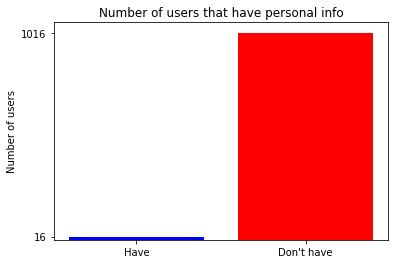

Total amount of users: 1032
Percentage of users with personal info: 1.550387596899225 %
Chat_ids with personal info: 80713059 (Barin_Ildar), 94552162 (egorka1397), 108431546 (mvshmakov), 120248031 (le_bourbier), 128855625 (JustDoItTim), 175030142 (N), 183082518 (DLDLU), 257765200 (xdownshiftx), 259600937 (pvsemk), 313741256 (Alexander), 335299756 (vvmosmvoretskiy), 339755055 (AHTOH4EK), 372861455 (Sde_or), 440708994 (spacedog46471), 501641067 (NN_Nikita_Nikitov), 1151088630 (Lizzztvv)


In [22]:
users_stats(database, True)

## Database migrations

In [0]:
import json
from gzip import GzipFile

In [0]:
def migrate_v1_v2(database):
    new_users = {}

    for (id, user) in database.users_db.items():
        if 'platoon' in user:
            del user['platoon']
        if 'platoonType' in user:
            del user['platoonType']
        new_users[id] = user

    print(f'Are you sure you want to migrate from v1 to v2? (y/n)')
    answer = input()

    if answer == 'y':
        db.reference('users').set(new_users)
        db.reference('version').set('v2')
        print('Database merged data and is using v3 schema')
    else:
        print('Database is using the same version')

In [0]:
def migrate_v2_v3(database):
    with GzipFile(backuper.basedir + 'users-7.04.20-21:56:47.json.gz', 'r') as fin:
        old_data = json.loads(fin.read().decode('utf-8'))['users']

    # Old (v1) and new (v2) unified data processing
    new_users = {}
    for (id, user) in {**old_data,
                       **database.users_db}.items():
        new_users[id] = {}

        # Related to new data
        if 'debug' in user:
            new_users[id] = {
                **user['debug']['user'],
                'lastAccess': user['debug']['lastAccess']}
        if 'defaultPlatoon' in user:
            new_users[id].update({'defaultPlatoon': user['defaultPlatoon']})
        new_users[id].update({'id': int(id)})

    print(f'Are you sure you want to migrate from v2 to v3? (y/n)')
    answer = input()

    if answer == 'y':
        db.reference('users').set(new_users)
        db.reference('version').set('v3')
        print('Database merged data and is using v3 schema')
    else:
        print('Database is using the same version')

In [0]:
# migrate_v1_v2(database)
# migrate_v2_v3(database)

## Sending messages

In [0]:
import json
import aiohttp
import asyncio
from tqdm.notebook import tqdm

In [0]:
# Fix for ipython event loop
import nest_asyncio
nest_asyncio.apply()

In [0]:
class MessageSender():
    headers = {'content-type': 'application/json'}
    stats = {}

    def __init__(self, bot_token=ENV["BOT_TOKEN"]):
        self.url = f'https://api.telegram.org/bot{bot_token}/sendMessage'

    def show_stats(self):
        response = self.stats['response']
        if (response['ok'] != True):
            print(f"{response['description']}. Try again.")
        else:
            chat = response['result']['chat']
            if 'username' in chat:
                print(f"Message \'{response['result']['text']}\' sent to {chat['username']} ({chat['first_name']})")
            else:
                print(f"Message \'{response['result']['text']}\' sent to {chat['first_name']}")
            print(f"At: {self.stats['date']}, Chat ID: {chat['id']}")

    def send_msg_to_chat(self, chat_id, text):
        loop = asyncio.get_event_loop()

        async def send_msg_to_chat_async():
            async with aiohttp.ClientSession() as session:
                self.stats = await self.send_msg_to_chat_async(session, chat_id, text)

        loop.run_until_complete(send_msg_to_chat_async())

    async def send_msg_to_chat_async(self, session, chat_id, text):
        payload = json.dumps({
            'chat_id': chat_id,
            'text': text
        })

        async with session.post(self.url, data=payload, headers=self.headers) as response:
            text = await response.text()

            return {
                'date': response.headers.get("DATE"),
                'response': json.loads(text),
            }

In [0]:
MAX_PARALLEL = 500

class MultipleMessagesSender(MessageSender):
    stats = []

    def __init__(self, db_instance, bot_token=ENV["BOT_TOKEN"]):
        super().__init__(bot_token)
        self.db = db_instance
    
    def __stat_count_with_error(self, counter, user):
        if user['response']['ok'] == True:
            return counter
        return counter + 1

    def show_errors_rate(self):
        objects = ('Succeded', 'Errored')
        y_pos = np.arange(len(objects))

        with_error = reduce(self.__stat_count_with_error, self.stats, 0)
        print(f"Successful messages: {(1 - with_error / len(self.stats)) * 100} %")

        x_pos = [
            len(self.stats) - with_error,
            with_error,
        ]

        plt.bar(y_pos[0], x_pos[0], color='blue', align='center')
        plt.bar(y_pos[1], x_pos[1], color='red', align='center')

        plt.ylabel('Number of requests')
        plt.yticks(x_pos)
        plt.xticks(y_pos, objects)
        plt.title('Number of succesful requests and errors')

        plt.show()

    def show_errors(self):
        if reduce(self.__stat_count_with_error, self.stats, 0) == 0:
            print('No errors!')
        else:
            def make_errors_map(errs, stat):
                if 'response' not in stat or 'description' not in stat['response']:
                    return errs
                description = stat['response']['description']
                if description in errs:
                    errs[description] += 1
                else:
                    errs[description] = 1
                return errs

            errors = reduce(make_errors_map, self.stats, {})

            x_pos = list(errors.values())
            y_pos = list(errors.keys())
            plt.bar(y_pos, x_pos, color='red', align='center')

            plt.ylabel('Number of errors')
            plt.yticks(x_pos)
            plt.xticks(y_pos, rotation=45)
            plt.title('Errors by description')

            plt.show()
            
    def show_problem_ids(self):
        if reduce(self.__stat_count_with_error, self.stats, 0) == 0:
            pass
        else:
            def get_problem_ids(ids, stat):
                if 'description' not in stat['response']:
                    return ids

                chat_id = stat['chat_id']
                if chat_id in ids:
                    return ids
                else:
                    ids.append(chat_id)
                    return ids

            failed_chat_ids = map(str, sorted(reduce(get_problem_ids, self.stats, [])))
            print(f"Problematic chat_ids: {', '.join(failed_chat_ids)}")

    def show_stats(self, show_problem_ids=False):
        self.show_errors_rate()
        self.show_errors()

        if show_problem_ids:
            self.show_problem_ids()

    def send_msg_to_everyone(self, text, parallel=MAX_PARALLEL):
        loop = asyncio.get_event_loop()
        future = asyncio.ensure_future(self.send_msg_to_everyone_async(text, parallel))
        loop.run_until_complete(future)

    async def bound_requests(self, session, semaphore, chat_id, text):
        # Getter function with semaphore.
        async with semaphore:
            return await self.send_msg_to_chat_async(session, chat_id, text)

    async def send_msg_to_everyone_async(self, text, debug=False, parallel=MAX_PARALLEL):
        tasks = []
        chat_ids = self.db.get_all_chat_ids(debug)
        semaphore = asyncio.Semaphore(parallel)

        # Create client session that will ensure we dont open new connection per each request.
        async with aiohttp.ClientSession() as session:
            for chat_id in chat_ids:
                task = asyncio.ensure_future(
                    self.bound_requests(session, semaphore, chat_id, text))
                tasks.append(task)

            for task in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
                await task

            results = await asyncio.gather(*tasks)
            
            def merge_stat_with_chat_id(accumulator, stat):
                stat[0]['chat_id'] = stat[1]
                accumulator.append(stat[0])
                return accumulator
                
            self.stats = list(reduce(merge_stat_with_chat_id, zip(results, chat_ids), []))

In [0]:
text = 'Привет, это новый бот! Вы можете выствить в настройках свой взвод, чтобы получать расписание в один клик!'
chat_id = database.DEBUG_USER_IDS[0]

In [32]:
sender = MessageSender()

sender.send_msg_to_chat(chat_id, text)
sender.show_stats()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The object should be created from async function


Message 'Привет, это новый бот! Вы можете выствить в настройках свой взвод, чтобы получать расписание в один клик!' sent to mvshmakov (Maxim)
At: Mon, 04 May 2020 13:46:13 GMT, Chat ID: 108431546


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: DeprecationWarning: The object should be created from async function



Successful messages: 16.666666666666664 %


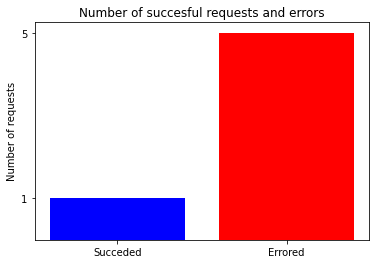

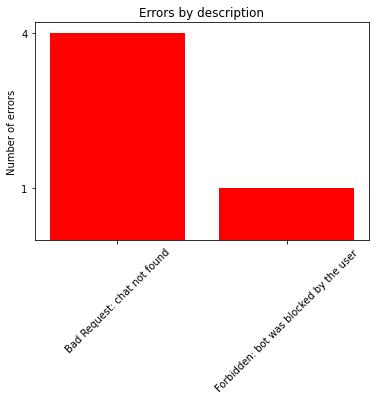

Problematic chat_ids: 565124, 733019, 947413, 1323215, 120248031


In [33]:
multiple_sender = MultipleMessagesSender(database)

multiple_sender.send_msg_to_everyone(text, True)
multiple_sender.show_stats(True)